In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from tqdm import tqdm
from omegaconf import OmegaConf
import umap.umap_ as umap
from models import JointLatentDiffusionNoisyClassifier
from models import get_model_class

from datasets import AdjustedSVHN, AdjustedMNIST, AdjustedFashionMNIST
import torchvision as tv
from ldm.util import default
from datasets import get_dataloaders


/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-04 00:24:34.469548: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 00:24:34.492717: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 00:24:34.833909: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appr

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
config = OmegaConf.load("/home/jk/Joint-Diffusion-in-Latent-Space/configs/latent_diffusion/semi-supervised/diffmatch_pooling/chest_xray_multilabel_imagenet_pretrain.yaml")
#config.model.params["ckpt_path"] = f"logs/JointDiffusion_2023-04-24T22-09-09/checkpoints/last.ckpt"
#model = JointLatentDiffusionNoisyClassifier(**config.model.get("params", dict()))
model = get_model_class(config.model.get("model_type"))(**config.model.get("params", dict()))

model.learning_rate = config.model.base_learning_rate
try:
    model.classifier_lr = config.model.classifier_lr
    print(['CLASSIFIER HAS SEPARATE LR'])
except:
    model.classifier_lr=None
    print(['CLASSIFIER HAS THE SAME LR'])

model.sampling_method = "unconditional"
model.gradient_guided_sampling=False
model.to(device)

dl_config = config.pop("dataloaders")
train_dls, val_dl, test_dl = get_dataloaders(**dl_config)

LatentSSLPoolingMultilabel: Running in eps-prediction mode
DiffusionWrapper has 257.73 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Restored from /home/jk/Joint-Diffusion-in-Latent-Space/models_imagenet/imagenet_vae.ckpt with 0 missing and 49 unexpected keys
Training LatentSSLPoolingMultilabel as an unconditional model.
Keeping EMAs of 312.
Restored from /home/jk/Joint-Diffusion-in-Latent-Space/models_imagenet/imagenet_diff_renamed_modified.cpkt with 72 missing and 709 unexpected keys
Missing Keys: ['model.diffusion_model.input_blocks.1.1.qkv.weight', 'model

/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


SSL DATSDET LOADING
[WARNING] Chest_xray_nih_sssl.py dataset - TO avoid errors we have val loader mocked with train data 2%!!!!
SSL DATSDET LOADING
[WARNING] Chest_xray_nih_sssl.py dataset - TO avoid errors we have val loader mocked with train data 2%!!!!
SSL DATSDET LOADING
[WARNING] Chest_xray_nih_sssl.py dataset - TO avoid errors we have val loader mocked with train data 2%!!!!
LENGTHS of train lab, train unlab, test 2077 86524 2077 25596


In [4]:
train_lab, train_unlab = train_dls

In [5]:
batch = next(iter(train_unlab))

In [6]:
batch[1].shape

torch.Size([32, 15])

In [7]:
@torch.no_grad()
def classify(batch):
    x = batch[0]
    x = model.to_latent(x, arrange=False)
    y = batch[1]
    t = torch.randint(
        0, model.num_timesteps, (x.shape[0],), device=device
    ).long()
    noise = torch.randn_like(x)
    x_noisy = model.q_sample(x_start=x, t=t, noise=noise)

    unet = model.model.diffusion_model
    representations = unet.just_representations(x, t, pooled=False)
    representations = model.transform_representations(representations)
    y_pred = model.classifier(representations)
    return y_pred

In [8]:
model.classifier

Sequential(
  (0): Dropout(p=0.0, inplace=False)
  (1): Linear(in_features=5632, out_features=1024, bias=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): Dropout(p=0.0, inplace=False)
  (4): Linear(in_features=1024, out_features=14, bias=True)
)

In [9]:
EXTRACTED_DATA_PATH = 'mediffusion_extracted_data'


In [10]:
import torch
import os
from tqdm import tqdm

@torch.no_grad()
def extract_representations(batch):
    x = batch[0]
    x = model.to_latent(x, arrange=False)
    y = batch[1]
    t = torch.randint(
        0, model.num_timesteps, (x.shape[0],), device=device
    ).long()
    noise = torch.randn_like(x)
    x_noisy = model.q_sample(x_start=x, t=t, noise=noise)

    unet = model.model.diffusion_model
    representations = unet.just_representations(x, t, pooled=False)
    representations = model.transform_representations(representations)
    return representations, y

def save_representations_and_targets(dataloader, save_path, file_prefix):
    os.makedirs(save_path, exist_ok=True)
    all_representations = []
    all_targets = []

    for batch in tqdm(dataloader, desc=f"Processing {file_prefix}"):
        representations, targets = extract_representations(batch)
        all_representations.append(representations.cpu())
        all_targets.append(targets.cpu())

    all_representations = torch.cat(all_representations)
    all_targets = torch.cat(all_targets)

    torch.save(all_representations, os.path.join(save_path, f"{file_prefix}_representations.pt"))
    torch.save(all_targets, os.path.join(save_path, f"{file_prefix}_targets.pt"))

# Example usage
#save_representations_and_targets(train_lab, EXTRACTED_DATA_PATH, 'train_lab')
#save_representations_and_targets(train_unlab, EXTRACTED_DATA_PATH, 'train_unlab')
#save_representations_and_targets(test_dl, EXTRACTED_DATA_PATH, 'test')


In [11]:
class RepresentationDataset(torch.utils.data.Dataset):
    def __init__(self, representations_path, targets_path):
        self.representations = torch.load(representations_path)
        self.targets = torch.load(targets_path)

    def __len__(self):
        return len(self.representations)

    def __getitem__(self, idx):
        return self.representations[idx], self.targets[idx][:-1].float()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
import numpy as np
from tqdm import tqdm

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for representations, targets in tqdm(train_loader, desc="Training"):
        representations, targets = representations.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(representations)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * representations.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def evaluate_model(model, val_loader, device):
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for representations, targets in tqdm(val_loader, desc="Evaluating"):
            representations, targets = representations.to(device), targets.to(device)
            outputs = model(representations)
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(outputs.cpu().numpy())
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)
    auroc = roc_auc_score(all_targets, all_predictions, average='macro', multi_class='ovr')
    return auroc


In [13]:
# Assuming RepresentationDataset class is defined as in previous step

# Paths to the saved data
train_lab_representations_path = os.path.join(EXTRACTED_DATA_PATH, 'train_lab_representations.pt')
train_lab_targets_path = os.path.join(EXTRACTED_DATA_PATH, 'train_lab_targets.pt')
train_unlab_representations_path = os.path.join(EXTRACTED_DATA_PATH, 'train_unlab_representations.pt')
train_unlab_targets_path = os.path.join(EXTRACTED_DATA_PATH, 'train_unlab_targets.pt')
test_representations_path = os.path.join(EXTRACTED_DATA_PATH, 'test_representations.pt')
test_targets_path = os.path.join(EXTRACTED_DATA_PATH, 'test_targets.pt')

# Create datasets
train_lab_dataset = RepresentationDataset(train_lab_representations_path, train_lab_targets_path)
train_unlab_dataset = RepresentationDataset(train_unlab_representations_path, train_unlab_targets_path)
test_dataset = RepresentationDataset(test_representations_path, test_targets_path)

# Create data loaders
train_loader = DataLoader(train_lab_dataset, batch_size=64, shuffle=True)
train_unl_loader = DataLoader(train_unlab_dataset, batch_size=64, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [14]:
# Assuming model.classifier is defined as provided
classifier = model.classifier.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Train and evaluate the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_model(classifier, train_unl_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")

    # Evaluate on test dataset
    test_auroc = evaluate_model(classifier, test_loader, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Test AUROC: {test_auroc:.4f}")


Training:   0%|          | 0/1352 [00:00<?, ?it/s]

Training: 100%|██████████| 1352/1352 [00:28<00:00, 47.81it/s]


Epoch 1/10, Training Loss: 0.2606


Evaluating: 100%|██████████| 400/400 [00:05<00:00, 69.15it/s]


Epoch 1/10, Test AUROC: 0.5900


Training: 100%|██████████| 1352/1352 [00:24<00:00, 54.75it/s]


Epoch 2/10, Training Loss: 0.1667


Evaluating: 100%|██████████| 400/400 [00:05<00:00, 75.02it/s]


Epoch 2/10, Test AUROC: 0.6104


Training: 100%|██████████| 1352/1352 [00:18<00:00, 73.63it/s]


Epoch 3/10, Training Loss: 0.1654


Evaluating: 100%|██████████| 400/400 [00:03<00:00, 116.18it/s]


Epoch 3/10, Test AUROC: 0.6102


Training: 100%|██████████| 1352/1352 [00:14<00:00, 94.75it/s] 


Epoch 4/10, Training Loss: 0.7736


Evaluating: 100%|██████████| 400/400 [00:02<00:00, 165.90it/s]


Epoch 4/10, Test AUROC: 0.5394


Training: 100%|██████████| 1352/1352 [00:08<00:00, 150.78it/s]


Epoch 5/10, Training Loss: 0.2621


Evaluating: 100%|██████████| 400/400 [00:02<00:00, 191.56it/s]


Epoch 5/10, Test AUROC: 0.6066


Training: 100%|██████████| 1352/1352 [00:10<00:00, 125.87it/s]


Epoch 6/10, Training Loss: 0.1827


Evaluating: 100%|██████████| 400/400 [00:02<00:00, 149.66it/s]


Epoch 6/10, Test AUROC: 0.6177


Training: 100%|██████████| 1352/1352 [00:21<00:00, 62.19it/s]


Epoch 7/10, Training Loss: 0.1694


Evaluating: 100%|██████████| 400/400 [00:04<00:00, 92.89it/s] 


Epoch 7/10, Test AUROC: 0.6237


Training: 100%|██████████| 1352/1352 [00:26<00:00, 51.27it/s]


Epoch 8/10, Training Loss: 0.1651


Evaluating: 100%|██████████| 400/400 [00:04<00:00, 99.85it/s] 


Epoch 8/10, Test AUROC: 0.6144


Training: 100%|██████████| 1352/1352 [00:16<00:00, 82.26it/s] 


Epoch 9/10, Training Loss: 0.1684


Evaluating: 100%|██████████| 400/400 [00:03<00:00, 111.38it/s]


Epoch 9/10, Test AUROC: 0.5399


Training: 100%|██████████| 1352/1352 [00:14<00:00, 90.69it/s] 


Epoch 10/10, Training Loss: 0.8401


Evaluating: 100%|██████████| 400/400 [00:03<00:00, 121.32it/s]


Epoch 10/10, Test AUROC: 0.5867


/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


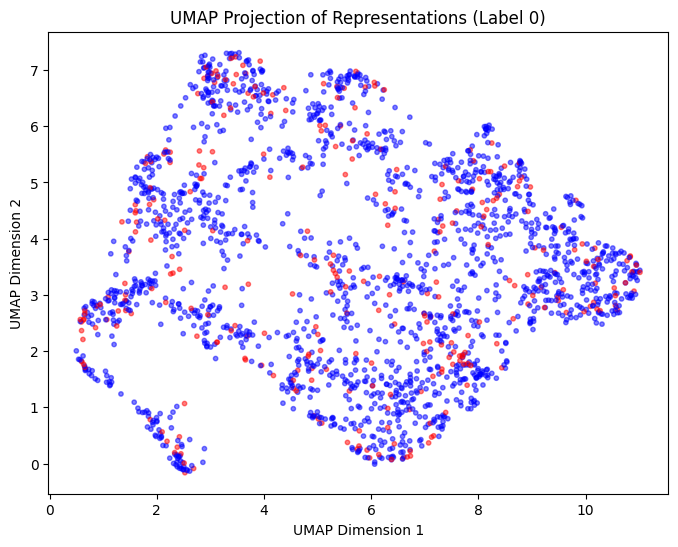

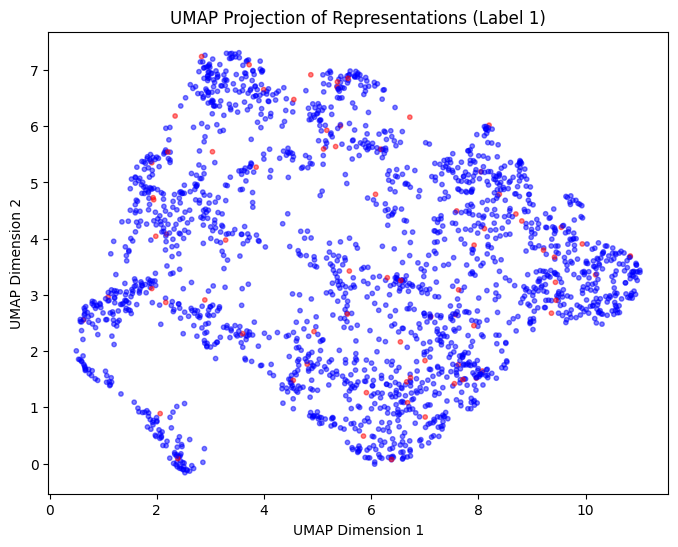

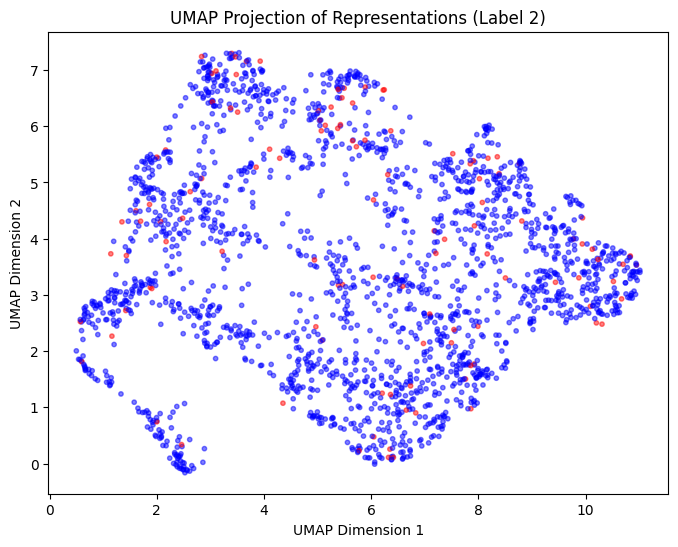

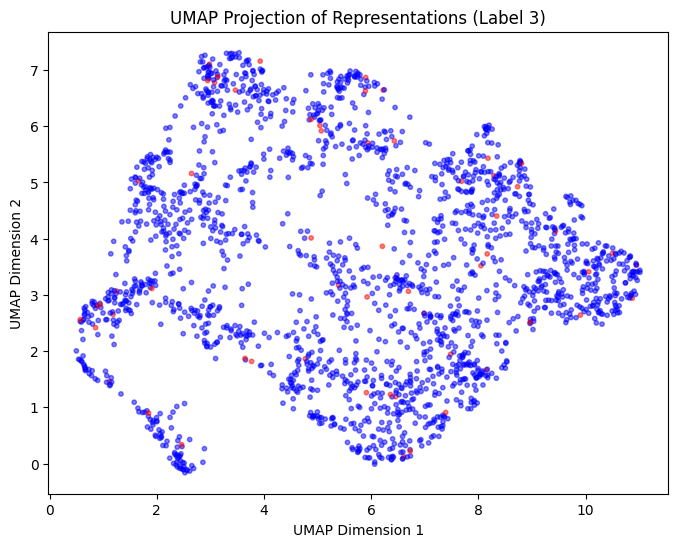

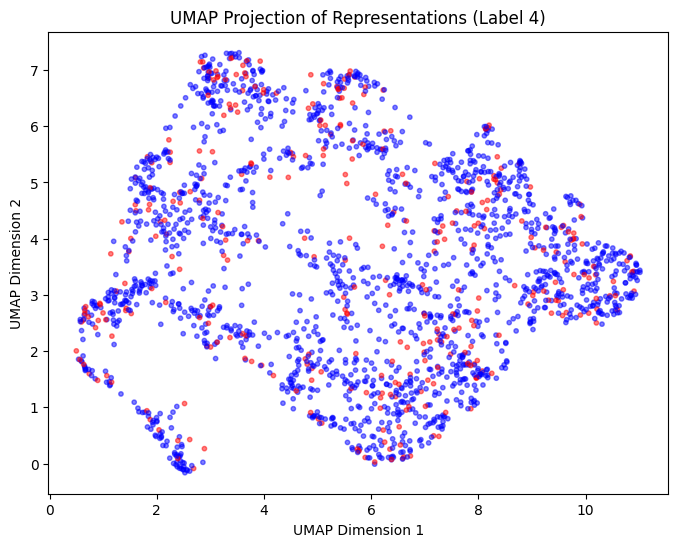

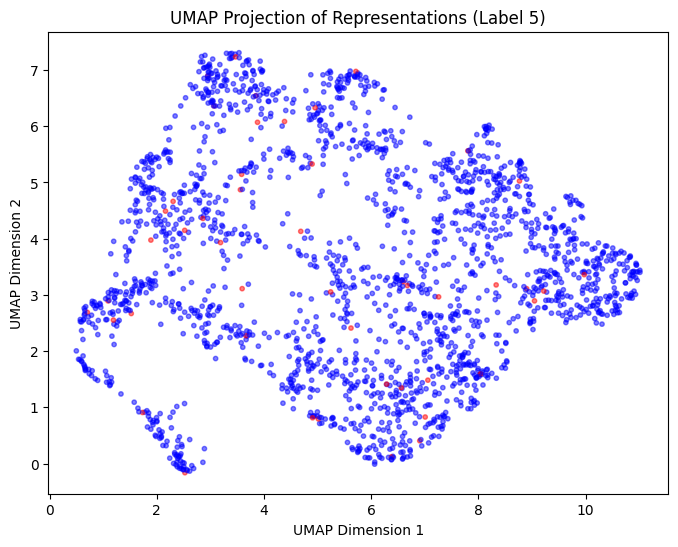

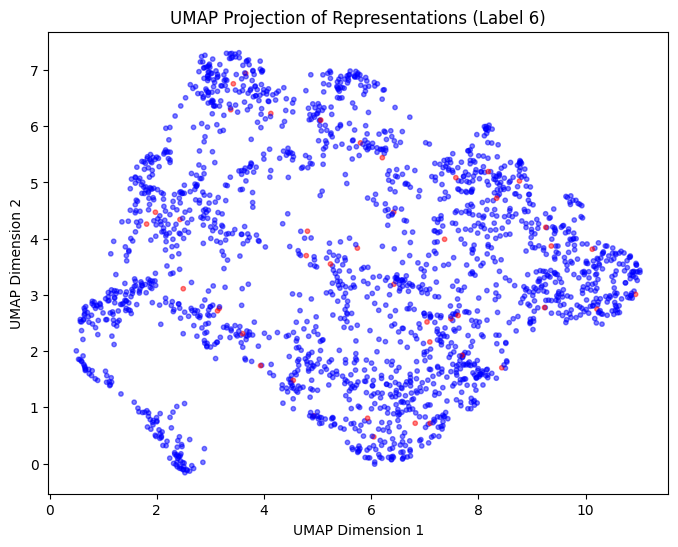

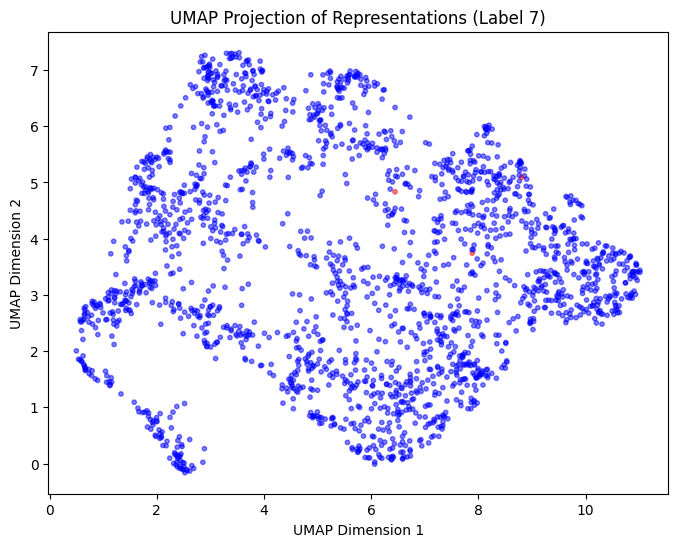

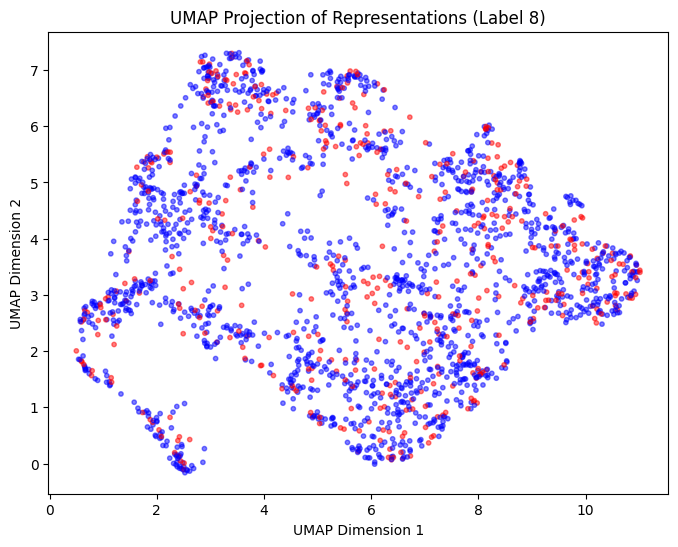

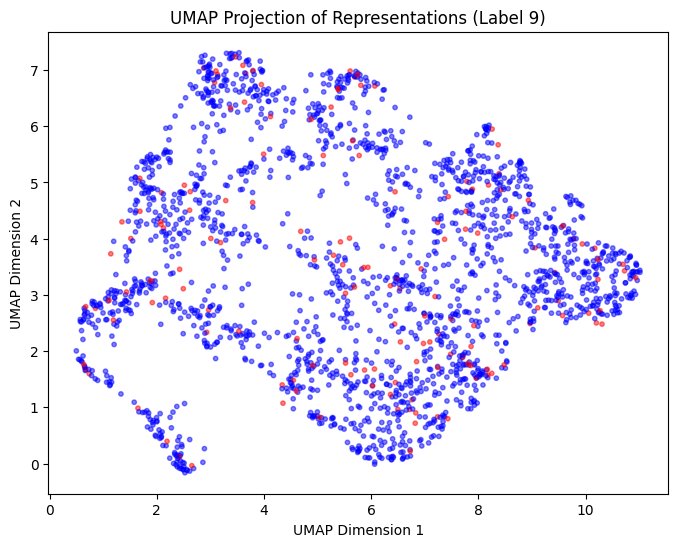

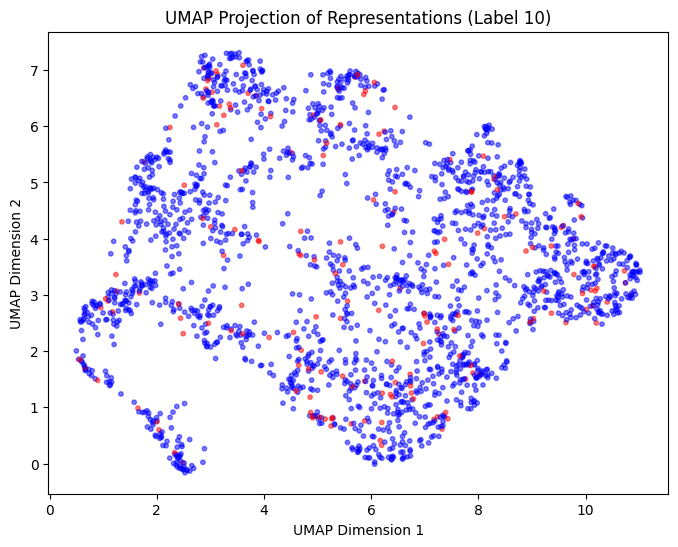

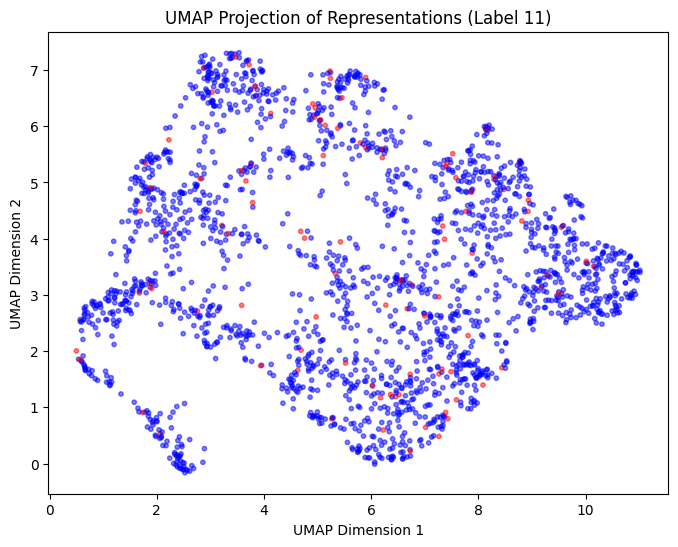

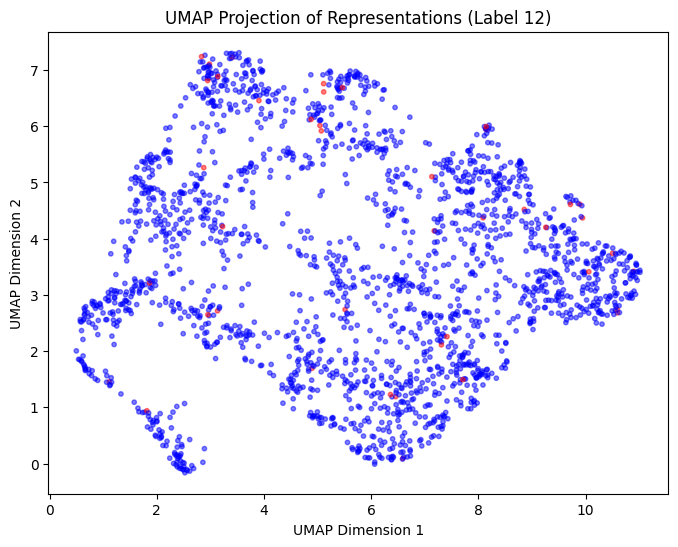

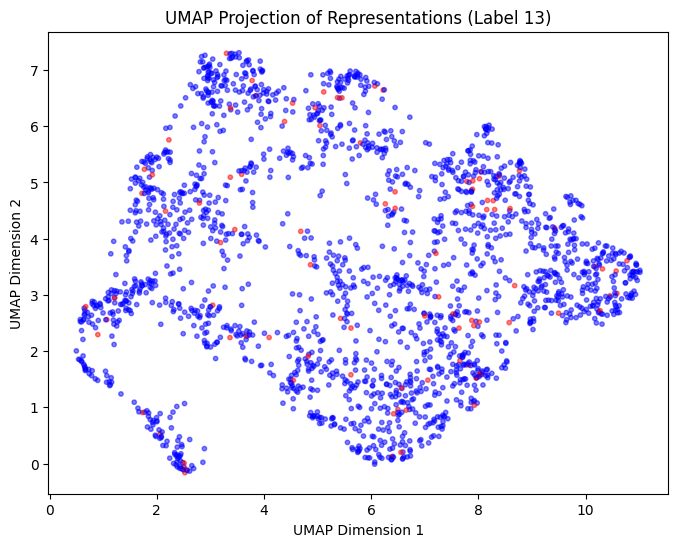

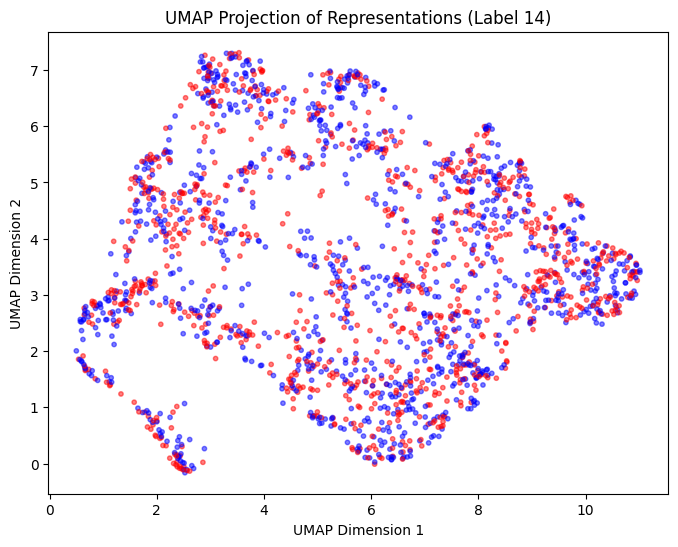

In [16]:
representations = torch.load(train_lab_representations_path)
targets = torch.load(train_lab_targets_path)

# Apply UMAP to reduce dimensions to 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
representations_2d = umap_model.fit_transform(representations)

# Plot the 2D representations
for i in range(targets.shape[1]):
    plt.figure(figsize=(8, 6))
    colors = ['red' if label == 1 else 'blue' for label in targets[:, i].numpy()]
    plt.scatter(representations_2d[:, 0], representations_2d[:, 1], c=colors, alpha=0.5, s=10)
    plt.title(f"UMAP Projection of Representations (Label {i})")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()